<a href="https://colab.research.google.com/github/kapitan05/Golem_Homework/blob/main/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praca domowa - regresja

Twoim zadaniem jest przewidywanie jakości wina na podstawie różnych właściwości - pH, zawartość alkoholu, chlorków etc.
Targetem jest kolumna "quality", która przyjmuje pięć wartości: 3, 4, 5, 6, 7, 8. Możliwe, że Twoje rozwiązanie będzie miało lepszy wynik jeśli będziesz zaokrąglać wyniki swojej predykcji.

#### Co dokładnie trzeba zrobić?

1. Poznaj swój dataset:
    - Które atrybuty są najważniejsze?
    - Czy warto [znormalizować](https://pl.wikipedia.org/wiki/Standaryzacja_(statystyka)) dane?


2. Przygotuj dane:
    - Jak podzielisz dane na testowe i treningowe?
    - Czy są wiersze/kolumny, które nie będą Ci potrzebne?
    
    
3. Napisz model:
    - Tak długo jak jest to regresja, wszystkie chwyty dozwolone! Możesz użyć makepipeline żeby złożyć parę modeli w jeden, albo spojrzeć do dokumentacji sklearn i poszukać czegoś nowego
    
    
4. Oceń model:
    - Jakie wyszło Ci MSE na zbiorze testowym? Generalniee każdy wynik na zbiorze testowym poniżej 0.5 jest całkiem niezły. Mi udało się zejść do 0.31

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, BayesianRidge, LassoLars, TweedieRegressor, Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:

data = pd.read_csv('https://raw.githubusercontent.com/KNSI-Golem/BootcampGeneral/main/2023/meetings/2_regression/data/winequality-red.csv', delimiter=',')

In [ ]:
data.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, ax=ax)
# plt.show()

In [ ]:
# dzielimy dane na target i features
target = 'quality'
features = [col for col in data.columns.to_list() if col != target]

# dla każdego feature rysujemy boxplot
fig, axis = plt.subplots(2, data.shape[1]//2, figsize=[20, 10])
idx=0;
axis=axis.flatten()
for feature in features:
    sns.boxplot(y=feature, data=data[[feature]], ax=axis[idx])
    idx+=1

plt.tight_layout()
plt.show()

In [ ]:
# wyrzucamy outlaiery
def remove_outliers(df,columns,n_std):
    for col in columns:
        mean = df[col].mean()
        sd = df[col].std()
        df = df[(df[col] <= mean+(n_std*sd))]

    return df

In [ ]:
data = remove_outliers(data, features, 3)

In [ ]:
fig, axis = plt.subplots(2, data.shape[1]//2, figsize=[20, 10])
idx=0;
axis=axis.flatten()
for feature in features:
    sns.boxplot(y=feature, data=data[[feature]], ax=axis[idx])
    idx+=1

plt.tight_layout()
plt.show()

In [ ]:
# dla każdej features rysujemy zależność od targetu
fig, axis = plt.subplots(data.shape[1]//2, 2, figsize=[20, 40])
idx=0;
axis=axis.flatten()
for feature in features:
    data.plot(y=target, x=feature, kind="scatter", ax=axis[idx])
    idx+=1

plt.tight_layout()
plt.show()

In [ ]:
def build_model(data, model, train_test_ratio, chosen_features, target, random_state=45):

    # dzielimy na train i test
    data_train, data_test = train_test_split(data, test_size=train_test_ratio, random_state=random_state)
    X_train, X_test = data_train[chosen_features], data_test[chosen_features]
    y_train, y_test = data_train[target], data_test[target]

    # cała regresja dzieje się tutaj
    model.fit(X_train, y_train)

    # przewidujemy wartość dla danych testowych
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # liczymy MSE
    MSE_train = mean_squared_error(y_train, y_pred_train)
    MSE_test = mean_squared_error(y_test, y_pred_test)
    print('MSE on training data:', MSE_train)
    print('MSE on test data:', MSE_test)

    return model, MSE_test

In [ ]:
# model liniowy z jedną zmienną
chosen_features = ['alcohol']
train_test_ratio=0.2

model, MSE= build_model(data, LinearRegression(), train_test_ratio, chosen_features, target)

# tutaj robię dictionary żeby później móc porównać modele
model_dict = {"linear_1": MSE}

In [ ]:
# można sobie zwizualizować
plt.figure(figsize=(10, 10))
sns.scatterplot(x='alcohol', y="quality", data=data[['alcohol','quality']])
tmp_x = np.array([[data['alcohol'].min(),],[data['alcohol'].max(),]])
tmp_y = model.predict(tmp_x)
plt.plot(tmp_x, tmp_y, color='r')
plt.show()

In [ ]:
# model liniowy z wieloma zmiennymi
chosen_features = ['alcohol', 'sulphates', 'citric acid', 'volatile acidity']
train_test_ratio=0.2

model, MSE= build_model(data, LinearRegression(), train_test_ratio, chosen_features, target)

# tutaj robię dictionary żeby później móc porównać modele
model_dict = {"linear_2": MSE}

In [ ]:
# model liniowy ze wszystkimi featurami

chosen_features = features

model, MSE = build_model(data, LinearRegression(), train_test_ratio, chosen_features, target)

model_dict["linear_3"] = MSE

In [37]:
degree = 2

model, MSE = build_model(data, make_pipeline(PolynomialFeatures(degree), LinearRegression()), train_test_ratio, chosen_features, target)
model_dict["linear_4"] = MSE

MSE on training data: 0.34258739685802264
MSE on test data: 0.4442495942214893


In [38]:
model_dict

{'linear_2': 0.4378339529799001,
 'linear_3': 0.424434210684876,
 'linear_4': 0.4442495942214893}

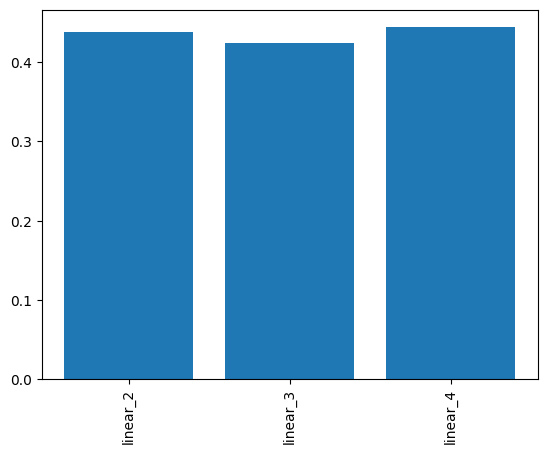

In [43]:
heights = model_dict.values()
labels = model_dict.keys()
plt.bar(range(len(labels)), heights)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.show()